**USING RESNET18 WITH AND WITHOUT PRETRAINED WEIGHTS**

**LOADING THE SSL MODEL AND TRAINING A CLASSIFIER ON TOP OF IT**

Reference 1: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

Reference 2: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

In [3]:
# Reproducibility.
SEED = 42

***

***

# Imports

## Libraries and modules

In [4]:
import os

import torch
import torchvision

from torchinfo import summary

import lightly
from lightly.models.modules.heads import SimSiamPredictionHead
from lightly.models.modules.heads import SimSiamProjectionHead

import matplotlib.pyplot as plt
import numpy as np
import math
import random

# Training checks.
import time

# Showing images in the notebook.
from IPython.display import Image
from IPython.core.display import HTML

/home/sfandres/Documents/Git/lulc/lulc-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

In [5]:
# Hyperparamenters.
input_size = 224  # old_input_size = 256
batch_size = 32   # old_batch_size = 128
num_workers = 8
epochs = 1

# Dimension of the embeddings.
num_ftrs = 512

# Dimension of the output of the prediction and projection heads.
out_dim = proj_hidden_dim = 512

# The prediction head uses a bottleneck architecture.
pred_hidden_dim = 128

## Reproducibility

In [6]:
# Seed torch and numpy.
os.environ['PYTHONHASHSEED'] = str(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Enable CUDNN deterministic mode.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Issues a warning if it is not met.
torch.use_deterministic_algorithms(True)

In [7]:
# For dataloaders.
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(SEED)

In [11]:
# Enable deterministic behavior using external GPU.
# %env CUBLAS_WORKSPACE_CONFIG=:4096:8
# %env CUBLAS_WORKSPACE_CONFIG=:16:8
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

***

***

# Loading dataset

In [12]:
data_dir_target = 'datasets/Sentinel2GlobalLULC_full_ratio_seed=' + str(SEED)

## Custom tranforms (w/o normalization)

Define the augmentations for self-supervised learning.

In [13]:
# Data augmentations for the train dataset.
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.RandomResizedCrop(size=input_size,
                                             scale=(0.2, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.GaussianBlur(21),
    torchvision.transforms.ToTensor(),
])

# Data augmentations for the val and test datasets.
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
])

## ImageFolder

In [15]:
# Loading the three datasets.
train_data = torchvision.datasets.ImageFolder(data_dir_target + '/train/',
                                              transform=train_transform)

val_data = torchvision.datasets.ImageFolder(data_dir_target + '/val/',
                                            transform=test_transform)

test_data = torchvision.datasets.ImageFolder(data_dir_target + '/test/',
                                             transform=test_transform)

## PyTorch dataloaders

In [17]:
# Dataloader for training.
dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

# Dataloader for embedding.
dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

## Check the balance and size of the dataset

In [18]:
# Check samples per class in train dataset.
print(np.unique(train_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([9800, 3259, 6208, 9800, 8355, 3105,  943, 9800, 7306, 4466, 2015,
        396,  880, 9800, 2739, 2710, 9793,  291,  340, 2943, 9800, 9800,
       9800, 1402,  589,  714,  247,  289, 8813]))


In [19]:
# Check samples per class in test dataset.
print(np.unique(test_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([2800,  932, 1775, 2800, 2389,  889,  271, 2800, 2089, 1276,  577,
        115,  253, 2800,  784,  775, 2799,   84,   99,  842, 2800, 2800,
       2800,  402,  169,  204,   71,   83, 2518]))


In [20]:
# Check the size of each dataset.
print(len(train_data.targets))
print(len(val_data.targets))
print(len(test_data.targets))

136403
19478
38996


## See some samples (pytorch dataset)

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


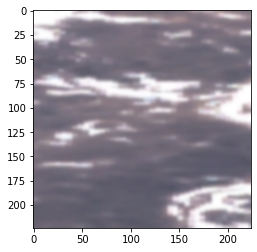

Label: 1


In [25]:
# Display image and label.
train_features, train_labels = next(iter(dataloader_train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(torch.permute(img, (1, 2, 0)), cmap="gray")
plt.show()
print(f"Label: {label}")

***

***

# ResNet18 from scrath

***

***

***

***

***

***

***

***

***

***

# Imports

In [1]:
import torch
import torchvision
from torchinfo import summary

import lightly
from lightly.models.modules.heads import SimSiamPredictionHead,SimSiamProjectionHead

import matplotlib.pyplot as plt
import numpy as np
import math
import random

/home/sfandres/Documents/Git/lulc/lulc-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
# Hyperparamenters.
input_size = 224  # input_size = 256
batch_size = 32   # batch_size = 128
num_workers = 8
epochs = 5

# Seed torch and numpy.
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

***

***

# Loading dataset

In [4]:
data_dir = 'datasets/Sentinel2GlobalLULC_ratio'

## Custom tranforms

In [5]:
# Define the augmentations for self-supervised learning.
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.RandomResizedCrop(size=input_size, scale=(0.2, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.GaussianBlur(21),
    torchvision.transforms.ToTensor(),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
])

## ImageFolder

In [6]:
# Loading both datasets.
train_data = torchvision.datasets.ImageFolder(data_dir + '/train/')

val_data = torchvision.datasets.ImageFolder(data_dir + '/val/')

test_data = torchvision.datasets.ImageFolder(data_dir + '/test/')

train_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(train_data)
test_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(test_data,
                                                                   transform=test_transform)

## Dataloaders

In [7]:
# Define the augmentations for self-supervised learning.
collate_fn_train = lightly.data.collate.BaseCollateFunction(train_transform)

# Create a dataloader for training and embedding.
dataloader_train_simsiam = torch.utils.data.DataLoader(
    train_data_lightly,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn_train,
    drop_last=True,
    num_workers=num_workers
)

dataloader_test = torch.utils.data.DataLoader(
    test_data_lightly,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

## Check balance and size

In [8]:
# Check samples per class in train dataset.
print(np.unique(train_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([9800, 3259, 6208, 9800, 8355, 3105,  943, 9800, 7306, 4466, 2015,
        396,  880, 9800, 2739, 2710, 9793,  291,  340, 2943, 9800, 9800,
       9800, 1402,  589,  714,  247,  289, 8813]))


In [9]:
# Check samples per class in val dataset.
print(np.unique(val_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([1400,  465,  886, 1400, 1193,  443,  134, 1400, 1043,  638,  288,
         56,  125, 1400,  391,  387, 1399,   41,   48,  420, 1400, 1400,
       1400,  200,   84,  102,   35,   41, 1259]))


In [10]:
print(len(train_data.targets))
print(len(val_data.targets))
print(len(test_data.targets))

136403
19478
38996


***

***

# Tutorial

In [11]:
data_transforms = {
    'train': transforms.Compose([
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.RandomResizedCrop(size=input_size, scale=(0.2, 1.0)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.GaussianBlur(21),
        torchvision.transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor()
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_workers)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Loading the model

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
resnet = torchvision.models.resnet18(weights=None)
pretrained_model = torch.nn.Sequential(*list(resnet.children())[:-1])
pretrained_model.load_state_dict(torch.load('pytorch_models/simsiam_backbone_resnet18'))
# model.eval() or model.train()

<All keys matched successfully>

In [80]:
print(resnet.conv1)
print(resnet.conv1.weight[63])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
tensor([[[ 0.0559,  0.0416,  0.0045, -0.0362, -0.0888, -0.0602, -0.0361],
         [ 0.0287,  0.0425, -0.0248, -0.0750, -0.0937, -0.0949, -0.0735],
         [ 0.0566,  0.0368,  0.0045, -0.0661, -0.1196, -0.1054, -0.0776],
         [ 0.0526,  0.0227, -0.0307, -0.0958, -0.1171, -0.1356, -0.1018],
         [ 0.0422,  0.0304, -0.0372, -0.0804, -0.1045, -0.1394, -0.1070],
         [ 0.0447,  0.0132, -0.0169, -0.0858, -0.1110, -0.1060, -0.0904],
         [ 0.0559,  0.0409, -0.0253, -0.0553, -0.0983, -0.0692, -0.0608]],

        [[ 0.0889,  0.0994,  0.0946,  0.0405,  0.0098,  0.0083,  0.0429],
         [ 0.0633,  0.0908,  0.0671,  0.0190,  0.0079,  0.0183,  0.0699],
         [ 0.0968,  0.0795,  0.0481,  0.0179,  0.0038, -0.0029,  0.0265],
         [ 0.1061,  0.1274,  0.0536,  0.0216,  0.0139,  0.0060,  0.0589],
         [ 0.0968,  0.1263,  0.0682,  0.0381,  0.0205,  0.0065,  0.0625],
         [ 0.1074,  0.0966,  0.05

In [15]:
# Adding a linear layer on top of the model (linear classifier).
model_ft = torch.nn.Sequential(
    pretrained_model,
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=512, out_features=num_classes, bias=True),
    # torch.nn.Softmax(dim=1)
)

In [16]:
summary(model_ft, input_size=(batch_size, 3, input_size, input_size))

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    [32, 29]                  --
├─Sequential: 1-1                             [32, 512, 1, 1]           --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        128
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [32, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [32, 64, 56, 56]          73,984
│    └─Sequential: 2-6                        [32, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [32, 128, 28, 28]         230,144
│    │    └─BasicBlock: 3-4                   [32, 128, 28, 28]         295,42

In [17]:
from torch.optim import lr_scheduler

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.9706 Acc: 0.6690
val Loss: 1.4007 Acc: 0.6036

Epoch 1/9
----------
train Loss: 0.6267 Acc: 0.7789
val Loss: 0.5117 Acc: 0.8134

Epoch 2/9
----------
train Loss: 0.5323 Acc: 0.8107
val Loss: 1.1991 Acc: 0.6423

Epoch 3/9
----------
train Loss: 0.4708 Acc: 0.8317
val Loss: 0.3651 Acc: 0.8682

Epoch 4/9
----------
train Loss: 0.4272 Acc: 0.8473
val Loss: 0.4448 Acc: 0.8492

Epoch 5/9
----------
train Loss: 0.3882 Acc: 0.8612
val Loss: 0.5118 Acc: 0.8239

Epoch 6/9
----------
train Loss: 0.3531 Acc: 0.8725
val Loss: 0.2956 Acc: 0.8915

Epoch 7/9
----------
train Loss: 0.2799 Acc: 0.8996
val Loss: 0.2379 Acc: 0.9130

Epoch 8/9
----------
train Loss: 0.2693 Acc: 0.9033
val Loss: 0.2389 Acc: 0.9147

Epoch 9/9
----------
train Loss: 0.2607 Acc: 0.9065
val Loss: 0.2331 Acc: 0.9143

Training complete in 53m 53s
Best val Acc: 0.914673


In [38]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 16))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} |\n'
                             f'real: {class_names[labels.cpu().data[j]]}')
                
                plt.imshow(torch.permute(inputs.cpu().data[j], (1, 2, 0)))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

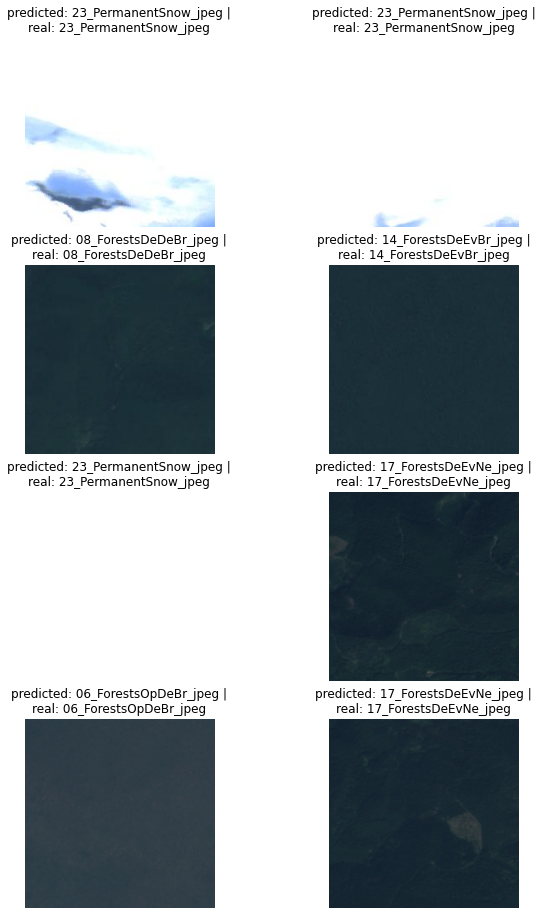

In [40]:
visualize_model(model_ft, num_images=8)

In [ ]:
print(model_ft)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
model_ft[0][0].weight

Parameter containing:
tensor([[[[ 2.4604e-02, -3.9565e-04,  9.4442e-03,  ...,  2.1839e-02,
            1.9308e-02,  2.7801e-02],
          [-1.1529e-02, -1.9889e-03,  6.1869e-04,  ...,  1.5930e-02,
            2.8849e-02, -2.5362e-03],
          [ 2.1794e-02,  1.6301e-02,  1.0232e-02,  ..., -1.1563e-02,
            1.3240e-02,  1.8114e-02],
          ...,
          [ 3.9381e-03,  8.4338e-03, -2.3085e-02,  ...,  3.9147e-02,
            1.9534e-02,  3.2469e-02],
          [ 7.6261e-03,  2.2951e-02,  1.1417e-02,  ...,  1.1386e-02,
            8.7117e-03,  3.2049e-03],
          [-3.1959e-03,  2.3103e-02,  3.5304e-03,  ...,  1.4036e-03,
            8.5128e-03,  1.0386e-02]],

         [[ 1.3647e-03,  8.2093e-03,  1.4210e-02,  ...,  2.0785e-03,
            2.1488e-02, -3.4086e-03],
          [ 1.0127e-02,  1.5786e-03, -2.8481e-03,  ..., -1.8699e-02,
           -5.4929e-03, -1.9491e-02],
          [ 4.8508e-03,  1.7433e-02, -4.2792e-02,  ...,  2.9306e-03,
            4.6097e-03,  8.6187e-03]

In [64]:
# for param in model_ft.parameters():
#     print(param.data)
#     break

for layer in model_ft.children():
    if isinstance(layer, torch.nn.Linear):
        print(layer.state_dict()['weight'])
        print(layer.state_dict()['bias'])

tensor([[ 0.0077,  0.0734,  0.0137,  ...,  0.0619, -0.0357, -0.0155],
        [-0.0196,  0.0131, -0.0068,  ...,  0.0610, -0.0257, -0.0691],
        [-0.0521,  0.0892, -0.0283,  ..., -0.0021, -0.0224,  0.0032],
        ...,
        [ 0.0083, -0.0437,  0.0379,  ...,  0.0418, -0.0245, -0.0232],
        [ 0.0123, -0.0249,  0.0012,  ...,  0.0079, -0.0306,  0.0694],
        [-0.0519,  0.0747,  0.0953,  ...,  0.0643, -0.0481,  0.0295]],
       device='cuda:0')
tensor([-0.0290,  0.0238, -0.0077,  0.0269, -0.0214, -0.0293,  0.0135,  0.0698,
         0.0343, -0.0078, -0.0211, -0.0381,  0.0070,  0.0366,  0.0464, -0.0393,
         0.0350,  0.0125, -0.0268,  0.0361, -0.0184, -0.0475, -0.0323,  0.0076,
         0.0110, -0.0304, -0.0620, -0.0317, -0.0092], device='cuda:0')
